# 📊 Tech Challenge - Análise e Previsão de Fatores de Estresse em Estudantes

## 📝 Definição do problema

* **Problema de Negócio:** Instituições de ensino precisam identificar estudantes em risco de estresse elevado para oferecer suporte adequado no momento certo. Este projeto visa criar uma solução preditiva que auxilie nessa identificação, permitindo intervenções mais direcionadas e eficazes.
* **Objetivo Técnico:** O problema foi enquadrado como um desafio de **Classificação Multiclasse**. O objetivo é treinar um modelo de Machine Learning para prever o nível de estresse de um estudante em uma de três categorias (0: baixo, 1: médio, 2: alto), utilizando a coluna `stress_level` como variável-alvo.

# 📖 Sumário
1. ⚙️ Configuração do Ambiente
2. 📥 Coleta, Armazenamento e Carregamento
3. 📊 Análise Exploratória de Dados (EDA)
4. 🧹 Pré-processamento e Preparação dos Dados
5. 🤖 Modelagem e Treinamento
6. 🛠️ Otimização de Hiperparâmetros
7. 🏁 Conclusão

# 1. ⚙️ Configuração do Ambiente

### 📌 Preparação do ambiente de trabalho

* **1. Importação de Bibliotecas:** Carregamos todas as ferramentas necessárias para manipulação de dados (pandas), visualização (matplotlib, seaborn), modelagem (scikit-learn) e outras operações. Centralizar as importações no início do notebook é uma boa prática que organiza o código e deixa claro quais são as dependências do projeto.
* **2. Configuração do Projeto:** Adicionamos o diretório raiz ao path do sistema para permitir a importação de módulos customizados, como o dicionário FEATURE_TRANSLATOR do arquivo config.py.
* **3. Definição de Constantes e Padrões:** Estabelecemos constantes globais, como o nome da variável alvo (TARGET_VARIABLE) e a semente de aleatoriedade (RANDOM_STATE), para garantir consistência e reprodutibilidade. Também definimos um estilo visual padrão para todos os gráficos do notebook.

In [1]:
# --- 1. Importação de Bibliotecas ---

# Manipulação de dados e sistema
import os
import sys
from io import BytesIO

# Análise e visualização
import boto3
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Componentes do Scikit-Learn para modelagem e avaliação
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# --- 2. Configuração do Projeto ---

# Adiciona o diretório raiz ao path para importar modulo de dicionário de tradução dos nomes das features
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

from config import FEATURE_TRANSLATOR

# --- 3. Padrões de Visualização ---

# Define um estilo visual consistente para todos os gráficos do notebook
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# --- 4. Mensagem de Confirmação ---

print("✅ Ambiente configurado com sucesso.")
print(
    f"   └── Dicionário 'FEATURE_TRANSLATOR' carregado com {len(FEATURE_TRANSLATOR)} traduções."
)

✅ Ambiente configurado com sucesso.
   └── Dicionário 'FEATURE_TRANSLATOR' carregado com 21 traduções.


In [2]:
# --- Constantes do Projeto ---

# Nome da variável alvo a ser utilizada em todo o notebook
TARGET_VARIABLE = "stress_level"

# Semente randômica para garantir a reprodutibilidade dos experimentos
RANDOM_STATE = 42

# 2. 📥 Coleta, Armazenamento e Carregamento

## 📌 Coleta de Dados

* **Fonte dos Dados:** Foi utilizado um dataset público da plataforma Kaggle, chamado "Student Stress Factors - A Comprehensive Analysis".
* **Justificativa:** A utilização de um dataset já existente foi uma decisão estratégica para otimizar o tempo e concentrar os esforços do projeto nas etapas de Análise, Modelagem e Deploy, que são o foco do desafio.

## 📌 Armazenamento dos Dados

* **Solução Adotada:** Para simular um ambiente de produção e garantir a reprodutibilidade, os dados foram armazenados em um sistema de armazenamento de objetos local (MinIO)].
* **Processo:** Um bucket chamado `student-stress` foi criado no servidor MinIO , e o dataset `StressLevelDataset.csv` foi carregado, tornando-se acessível via serviço para a etapa de análise.

## 📌 Carregamento dos Dados

* **Processo:** O código abaixo configura as credenciais de acesso (priorizando variáveis de ambiente por segurança) e estabelece uma conexão com o MinIO. Em seguida, ele lê o arquivo `StressLevelDataset.csv` diretamente do bucket de armazenamento para um DataFrame do pandas, que é a estrutura de dados fundamental que usaremos para toda a análise.


In [3]:
# --- 1. Configurações de Conexão ---
# As credenciais são carregadas de variáveis de ambiente para segurança.
# Valores padrão são fornecidos para facilitar a execução em ambiente local.
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT", "127.0.0.1:9000")
MINIO_ACCESS_KEY = os.getenv("MINIO_ACCESS_KEY", "minioadmin")
MINIO_SECRET_KEY = os.getenv("MINIO_SECRET_KEY", "minioadmin")
BUCKET_NAME = "student-stress"
OBJECT_NAME = "StressLevelDataset.csv"

# --- 2. Carregamento dos Dados ---
try:
    # Inicializa o cliente S3 para interagir com o MinIO
    s3_client = boto3.client(
        "s3",
        endpoint_url=f"http://{MINIO_ENDPOINT}",
        aws_access_key_id=MINIO_ACCESS_KEY,
        aws_secret_access_key=MINIO_SECRET_KEY,
        config=boto3.session.Config(signature_version="s3v4"),
    )

    # Busca o objeto no bucket e o carrega em um DataFrame
    response = s3_client.get_object(Bucket=BUCKET_NAME, Key=OBJECT_NAME)
    df = pd.read_csv(BytesIO(response["Body"].read()))

    print(
        f"✅ Dataset '{OBJECT_NAME}' carregado com sucesso do bucket '{BUCKET_NAME}'."
    )

except Exception as e:
    print(f"❌ Erro ao carregar o dataset do MinIO: {e}")

✅ Dataset 'StressLevelDataset.csv' carregado com sucesso do bucket 'student-stress'.


# 3. 📊 Análise Exploratória de Dados (EDA)

A Análise Exploratória de Dados (EDA) é uma das etapas fundamentais de qualquer projeto de Machine Learning. É quando realmente começamos a conhecer os dados: entender como estão organizados, descobrir padrões escondidos, identificar problemas e extrair os primeiros insights que vão orientar todo o trabalho seguinte — desde a limpeza até a construção dos modelos.
Vamos dividir nossa EDA em três etapas:
* **Análise Estrutural e de Qualidade:** verificar dimensões, tipos de variáveis, dados ausentes e registros duplicados.
* **Análise Descritiva:** calcular estatísticas básicas e observar uma amostra representativa do conjunto.
* **Visualização de Dados:** criar gráficos que revelam a distribuição das variáveis e as relações entre elas.

## 📌 Análise Estrutural e de Qualidade
* **Objetivo:** Ter uma visão geral da estrutura do dataset e verificar a integridade dos dados (nulos e duplicados).

In [4]:
# 1. Dimensões do DataFrame
print(f"O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.\n")

# 2. Análise de Tipos de Dados e Valores Nulos
print("Análise de tipos de dados e valores nulos por coluna:")
info_df = pd.DataFrame(
    {
        "Tipo de Dado": df.dtypes,
        "Valores Nulos": df.isnull().sum(),
        "% Nulos": (df.isnull().sum() / df.shape[0]) * 100,
    }
)
display(info_df.sort_values(by="% Nulos", ascending=False))

# 3. Verificação de Linhas Duplicadas
num_duplicates = df.duplicated().sum()
if num_duplicates > 0:
    print(f"\n❌ Alerta: Foram encontradas {num_duplicates} linhas duplicadas.")
else:
    print("\n✅ Nenhuma linha duplicada foi encontrada no dataset.")

O dataset possui 1100 linhas e 21 colunas.

Análise de tipos de dados e valores nulos por coluna:


,Tipo de Dado,Valores Nulos,% Nulos
anxiety_level,int64,0,0.0
basic_needs,int64,0,0.0
bullying,int64,0,0.0
extracurricular_activities,int64,0,0.0
peer_pressure,int64,0,0.0
social_support,int64,0,0.0
future_career_concerns,int64,0,0.0
teacher_student_relationship,int64,0,0.0
study_load,int64,0,0.0
academic_performance,int64,0,0.0



✅ Nenhuma linha duplicada foi encontrada no dataset.


### 📋 Análise dos Resultados

#### **Inspeção Inicial:**

A análise estrutural, realizada com os comandos `.shape`, `.info()` e `.duplicated()`, revelou as seguintes conclusões:

* **Dimensões:** Temos 1100 registros distribuídos em 21 colunas.
* **Valores Ausentes:** Não encontramos nenhum valor nulo no dataset. Isso nos poupa da necessidade de aplicar técnicas de imputação de dados.
* **Registros Duplicados:** Não há linhas duplicadas. Cada registro é único, o que garante a integridade da nossa base.
* **Tipos de Dados:** Todas as colunas já estão em formato numérico (`int64`). Isso simplifica bastante o pré-processamento, já que não precisaremos fazer encoding de variáveis categóricas.

## 📌 Análise Descritiva
* **Objetivo:** Analisar uma pequena amostra dos dados (5 primeiras linhas do dataset) para entender a natureza das colunas e, em seguida, obter um resumo estatístico das variáveis numéricas, como média, desvio padrão, mínimo e máximo.

In [5]:
# 1. Amostra dos Dados
print("As 5 primeiras linhas do dataset:")
display(df.head())

# 2. Estatísticas Descritivas
print("\nResumo estatístico das variáveis numéricas:")
descriptive_stats = df.describe().T
display(descriptive_stats.style.format("{:.2f}"))

As 5 primeiras linhas do dataset:


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1



Resumo estatístico das variáveis numéricas:


,count,mean,std,min,25%,50%,75%,max
anxiety_level,1100.00,11.06,6.12,0.00,6.00,11.00,16.00,21.00
self_esteem,1100.00,17.78,8.94,0.00,11.00,19.00,26.00,30.00
mental_health_history,1100.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
depression,1100.00,12.56,7.73,0.00,6.00,12.00,19.00,27.00
headache,1100.00,2.51,1.41,0.00,1.00,3.00,3.00,5.00
blood_pressure,1100.00,2.18,0.83,1.00,1.00,2.00,3.00,3.00
sleep_quality,1100.00,2.66,1.55,0.00,1.00,2.50,4.00,5.00
breathing_problem,1100.00,2.75,1.40,0.00,2.00,3.00,4.00,5.00
noise_level,1100.00,2.65,1.33,0.00,2.00,3.00,3.00,5.00
living_conditions,1100.00,2.52,1.12,0.00,2.00,2.00,3.00,5.00


### 📋 Análise dos Resultados

#### **Análise de Outliers e Natureza das Variáveis:**

A análise das estatísticas descritivas (`.describe()`) nos permite entender a natureza das nossas variáveis:

* **Natureza Ordinal:** A maioria das features são ordinais, representando escalas fixas — geralmente de 0 a 5.
* **Tratamento de Outliers:** Considerando que os valores nos extremos dessas escalas (como 0 ou 5) são respostas válidas e representam os limites das opções disponíveis para os estudantes, a aplicação de técnicas de remoção de outliers seria inadequada. Tais valores são fundamentais para o modelo entender os diferentes níveis de estresse.
* **Decisão:** Nenhuma ação de tratamento de outliers será realizada.

## 📌 Visualização de dados
* **Objetivo:** Extrair insights sobre as distribuições de dados e as relações entre os fatores pesquisados e o nível de estresse dos estudantes.

**Nesta subseção, exploraremos:**
* A distribuição da nossa variável alvo (stress_level) para verificar o balanceamento entre as classes.
* A distribuição individual de cada feature preditiva.
* A relação entre cada feature e a variável alvo. 
* Uma matriz de correlação para identificar relações lineares entre as variáveis.

### 🔎 Distribuição da Variável Alvo

* **Objetivo:** Verificar a distribuição da variável alvo  `stress_level` com o intuito de identificar se as classes (0: baixo, 1: médio, 2: alto) estão balanceadas. Um desbalanceamento severo poderia enviesar o modelo, fazendo-o performar melhor para as classes mais frequentes.

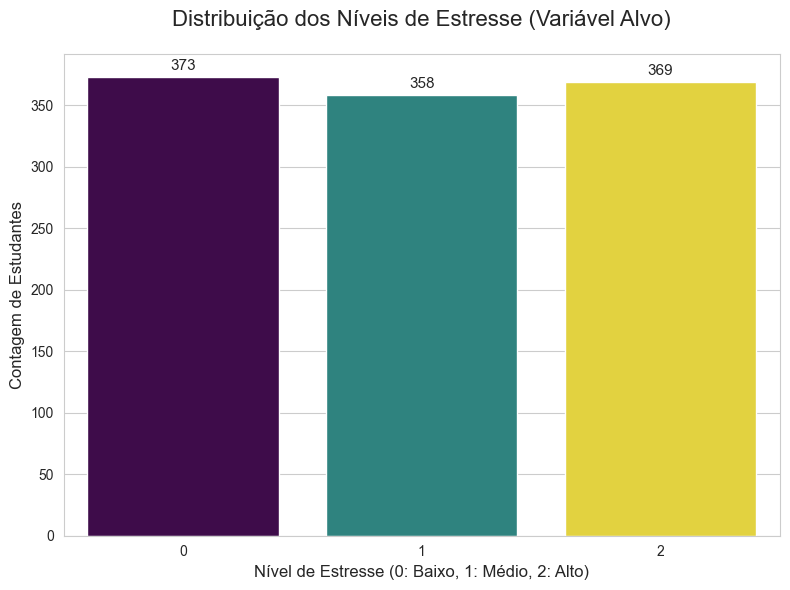

In [6]:
# Configuração da área de plotagem
fig, ax = plt.subplots(figsize=(8, 6))

# Gráfico de contagem para a variável alvo
sns.countplot(
    data=df,
    x=TARGET_VARIABLE,
    hue=TARGET_VARIABLE,
    palette="viridis",
    order=[0, 1, 2],
    legend=False,
    ax=ax,
)

# Adiciona rótulos de contagem sobre as barras
for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=11)

# Títulos e rótulos
ax.set_title("Distribuição dos Níveis de Estresse (Variável Alvo)", fontsize=16, pad=20)
ax.set_xlabel("Nível de Estresse (0: Baixo, 1: Médio, 2: Alto)", fontsize=12)
ax.set_ylabel("Contagem de Estudantes", fontsize=12)

plt.tight_layout()
plt.show()

#### 📋 Análise dos Resultados

##### **Conclusão sobre a Variável-Alvo**
A distribuição de stress_level mostra um balanceamento excelente entre as três classes:

* **Baixo (0):** 373 registros
* **Médio (1):** 358 registros
* **Alto (2):** 369 registros

Essa distribuição equilibrada é ideal para o treinamento do modelo de classificação. Não precisaremos aplicar técnicas de balanceamento de classes, o que simplifica nosso pipeline e evita possíveis vieses artificiais.

### 🔎 Análise Univariada

* **Objetivo:** Visualizar a distribuição de cada variável preditiva para entender o perfil geral das respostas dos estudantes. Como a maioria das variáveis é ordinal (escalas de 0 a 5), gráficos de contagem são ideais.

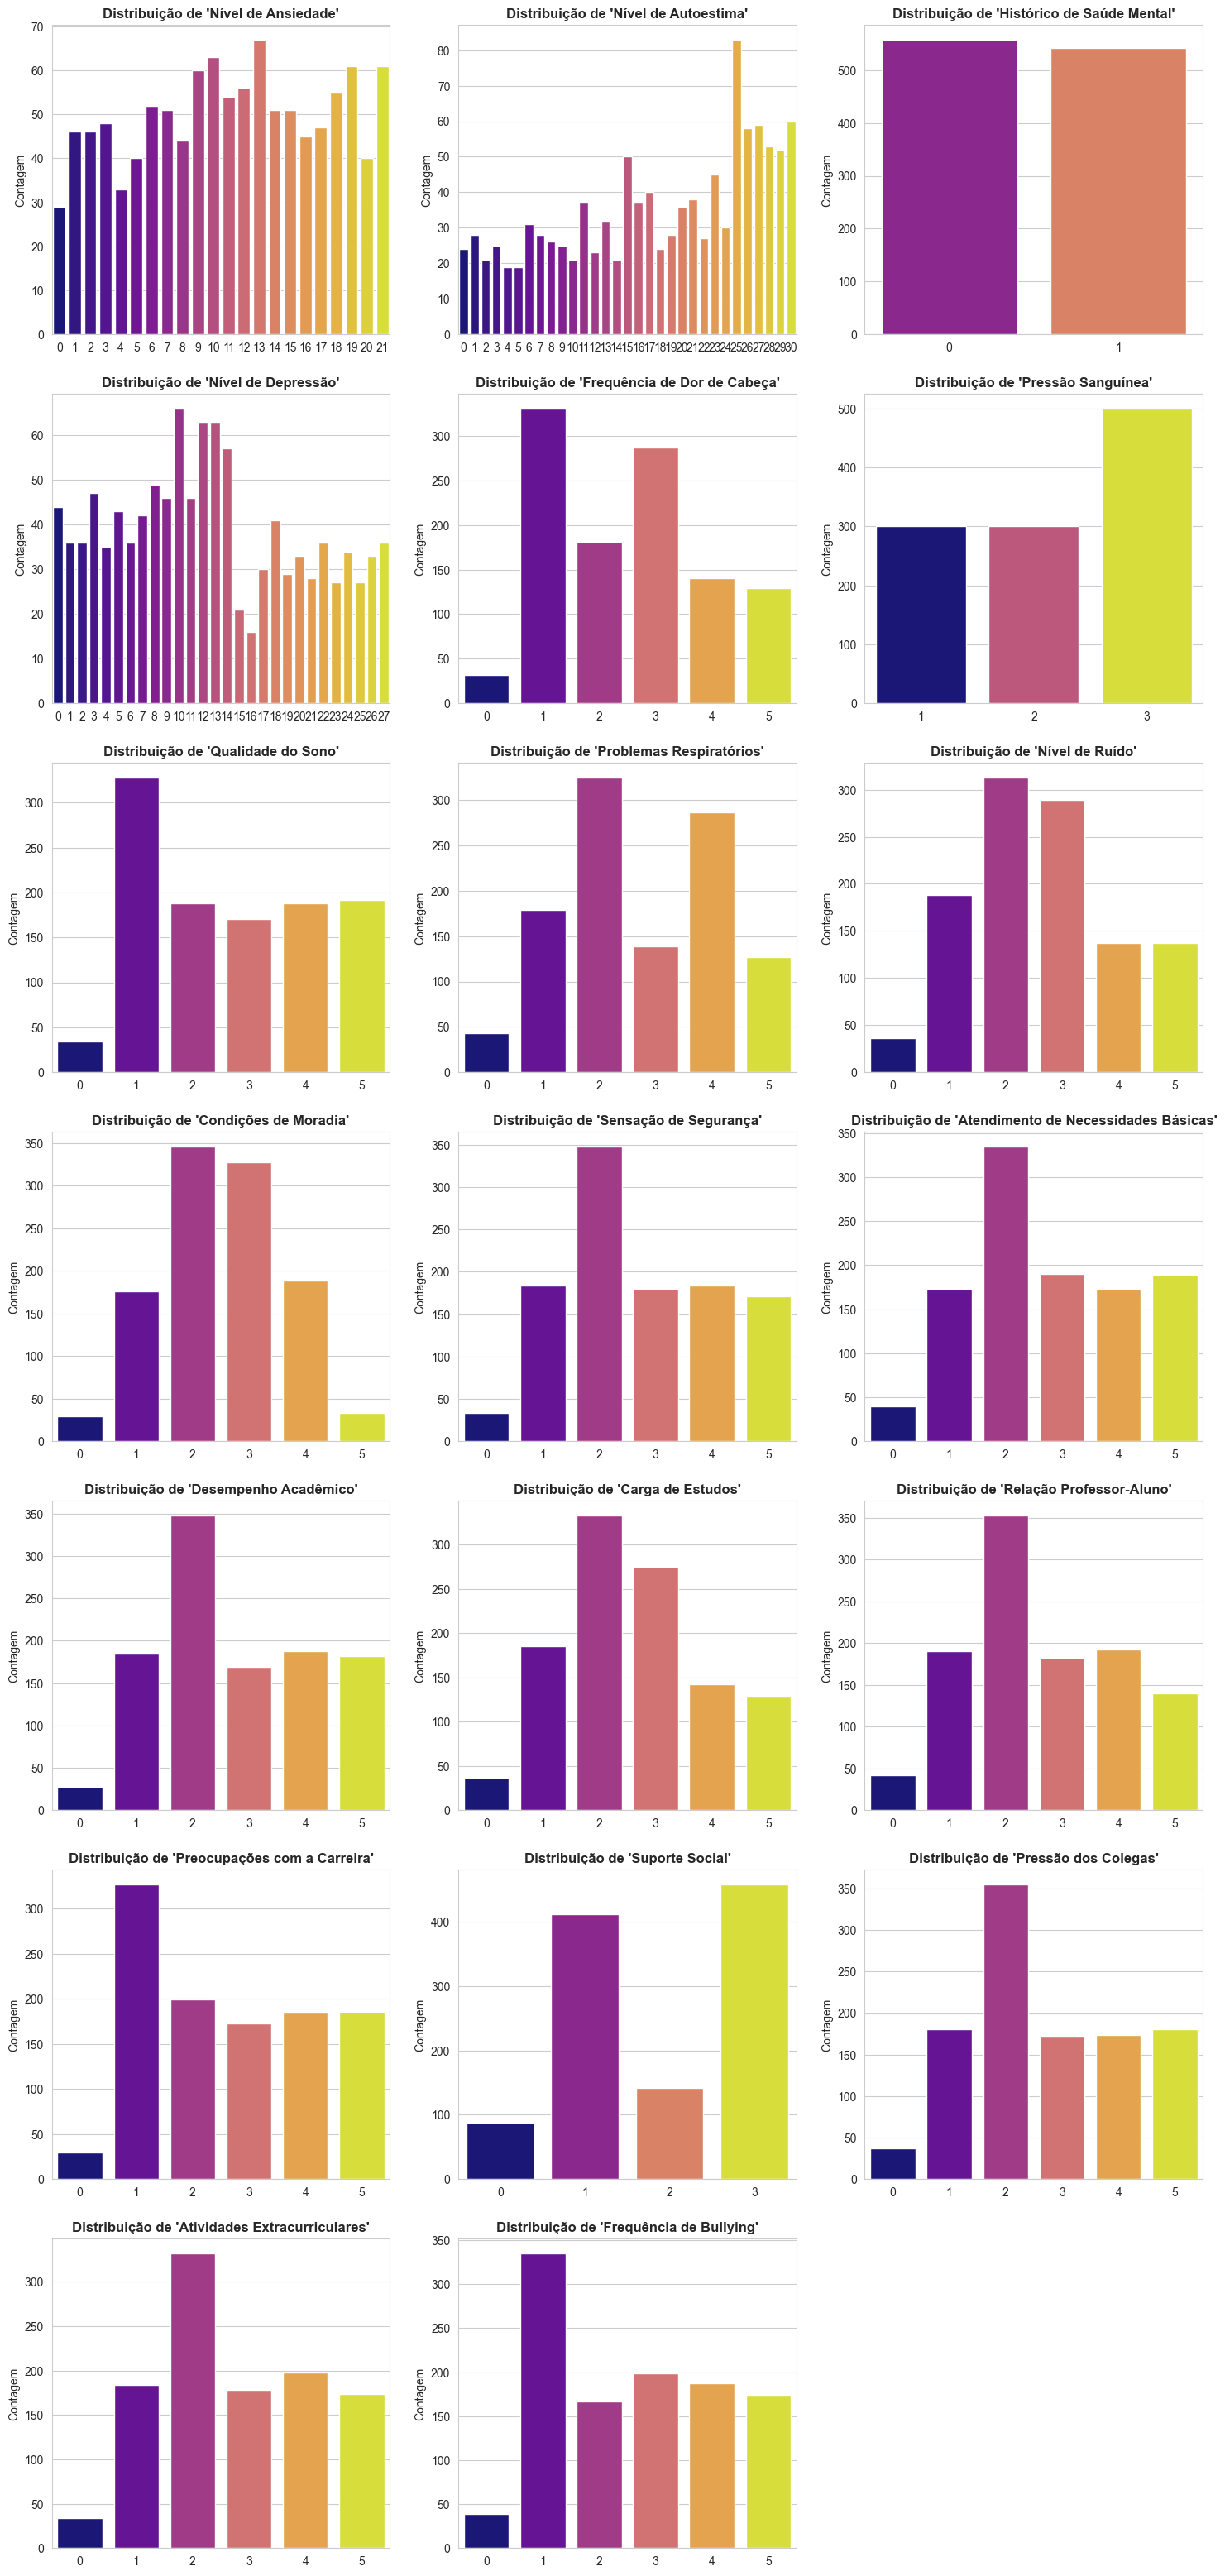

In [7]:
# Identifica as features preditivas (excluindo a variável alvo)
features = df.drop(TARGET_VARIABLE, axis=1).columns.tolist()

# Define a estrutura da grade de visualização
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols

# Cria a figura e os eixos para os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4.5))
axes = axes.flatten()

# Gera um gráfico de contagem para cada feature
for i, feature in enumerate(features):
    ax = axes[i]
    titulo_grafico = FEATURE_TRANSLATOR.get(feature, feature)

    sns.countplot(
        x=feature, data=df, ax=ax, palette="plasma", hue=feature, legend=False
    )
    ax.set_title(f"Distribuição de '{titulo_grafico}'", fontsize=12, weight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Contagem")

# Oculta eixos não utilizados
for i in range(len(features), len(axes)):
    axes[i].axis("off")

plt.tight_layout(pad=2.0)
plt.show()

#### 📋 Análise dos Resultados

##### **Observações Gerais e Conclusões da Análise Univariada:**

Os gráficos de distribuição revelam um retrato multifacetado dos estudantes. Vamos explorar os principais achados por categoria:

**1. Fatores Acadêmicos e de Carreira:**
* **`Desempenho Acadêmico`**: A autoavaliação de desempenho se concentra no nível 2 (regular). Poucos se classificam no nível mais baixo, e uma parcela relevante se avalia nos níveis altos (4 e 5). Isso sugere que o desempenho acadêmico pode não estar tão atrelado ao estresse quanto imaginamos.
* **`Carga de Estudos`**: A percepção de carga de estudos está concentrada nos níveis intermediários a altos (picos em 2 e 3). Tudo indica um ambiente acadêmico exigente e uma pressão constante.
* **`Relação Professor-Aluno`**: O pico no nível 2 sugere que a relação com professores é vista como funcional ou neutra. A baixa frequência nos extremos (0 e 5) indica mais distância do que conexão forte ou conflito aberto.
* **`Preocupações com a Carreira`**: As preocupações com a carreira se concentram em intensidade baixa a moderada (picos em 1 e 2). Não parece ser o principal vetor de ansiedade comparado a outros fatores.
* **`Atividades Extracurriculares`**: A maioria participa de alguma atividade extracurricular, com destaque para o nível 2. Isso pode estar relacionado à sobrecarga de compromissos e ao sono insuficiente.

**2. Fatores Psicológicos e de Saúde Mental:**
* **`Histórico de Saúde Mental`**: A distribuição é praticamente 50/50 entre estudantes com e sem histórico clínico de saúde mental. Esse equilíbrio é importante — não temos uma classe minoritária aqui.
* **`Nível de Ansiedadel` e `Nível de Depressão`**: Distribuições amplas, sem picos definidos. Isso confirma a heterogeneidade da amostra: temos desde estudantes assintomáticos até aqueles com sintomas severos. O modelo precisará lidar com esse espectro completo.
* **`Nível de Autoestima`**: A tendência geral é de autoestima moderada a alta, com concentração em escores acima de 15. O pico notável no nível 25 pode indicar um subgrupo com autoconfiança particularmente elevada — ou talvez seja apenas um artefato da escala de medição. 

**3. Fatores Sociais e de Relacionamento:**
* **`Suporte Social`**: A distribuição bimodal é reveladora: há dois grupos distintos e igualmente expressivos. Um percebe o apoio social como forte (pico no 3), enquanto o outro o considera insuficiente (pico no 1). O suporte social claramente não é uniforme nesta amostra.
* **`Frequência de Bullying`**: A distribuição indica que o Frequência de Bullying é prevalente. O pico no nível 1 e as baixas ocorrências no nível 0 sugerem que a maioria já sofreu algum tipo de Frequência de Bullying, ainda que de baixa intensidade.O pico no nível 1 e as baixas ocorrências no nível 0 sugerem que a maioria dos estudantes já sofreu algum tipo de Frequência de Bullying, ainda que de baixa intensidade.
* **`Pressão dos Colegas`**: A pressão dos colegas é percebida com intensidade moderada (pico no 2) — presente, mas não extrema, no cotidiano dos estudantes.

**4. Fatores de Bem-Estar e Ambiente:**
* **`Condições de Moradia`**: Concentração nos níveis intermediários (2, 3 e 4). A maioria não enfrenta privações severas nem vive em abundância — um perfil socioeconômico intermediário.
* **`Sensação de Segurança` e `Atendimento de Necessidades Básicas`**: A grande maioria se sente segura e com necessidades básicas atendidas, mas a percepção é mais "razoável" (pico no 2) do que "excelente". A quase ausência de respostas no nível 0 é um sinal positivo.
* **`Nível de Ruído`**: Concentração nos níveis intermediários. Ambientes perfeitamente silenciosos não são a realidade para a maioria.
* **`Qualidade do Sono`**: Aqui temos um ponto crítico de atenção. A forte concentração em níveis baixos, com pico expressivo no nível 1, indica que sono de má qualidade é uma experiência comum e prevalente neste grupo.

**5. Sintomas Fisiológicos:**
* **`Pressão Sanguínea`**: Um indicador preocupante. A tendência de elevação é clara, com quase metade dos estudantes no nível mais alto. Um forte sinal de alerta que pode estar ligado ao estresse crônico.
* **`Frequência de Dor de Cabeça` e `Problemas Respiratórios`**: Estes são sintomas crônicos para a maioria. A baixa contagem no nível 0 (ausência de sintomas) é reveladora: dores de cabeça e dificuldades respiratórias parecem normalizadas nesta população.


##### **Perfil do Estudante Típico**

Consolidando os achados, temos um retrato preocupante:
O estudante médio desta amostra vive uma rotina acadêmica exigente, com autoavaliação de desempenho apenas regular. Sintomas físicos crônicos — dores de cabeça, problemas respiratórios e, mais alarmante, pressão arterial elevada — são comuns. A má qualidade do sono é realidade para a grande maioria.
O ambiente social traz desafios próprios. O Frequência de Bullying é uma experiência prevalente, e o suporte social é polarizado: ou é forte, ou é insuficiente. O estudante típico vive em contexto socioeconômico intermediário, com necessidades básicas atendidas, mas lida com uma carga de estudos e atividades que pode estar contribuindo para seu esgotamento físico e mental.


### 🔎 Análise Bivariada

* **Objetivo:** Investigar como cada variável preditiva se relaciona com a nossa variável alvo, `stress_level`. Isso nos ajudará a identificar quais fatores parecem ter maior influência sobre o estresse.

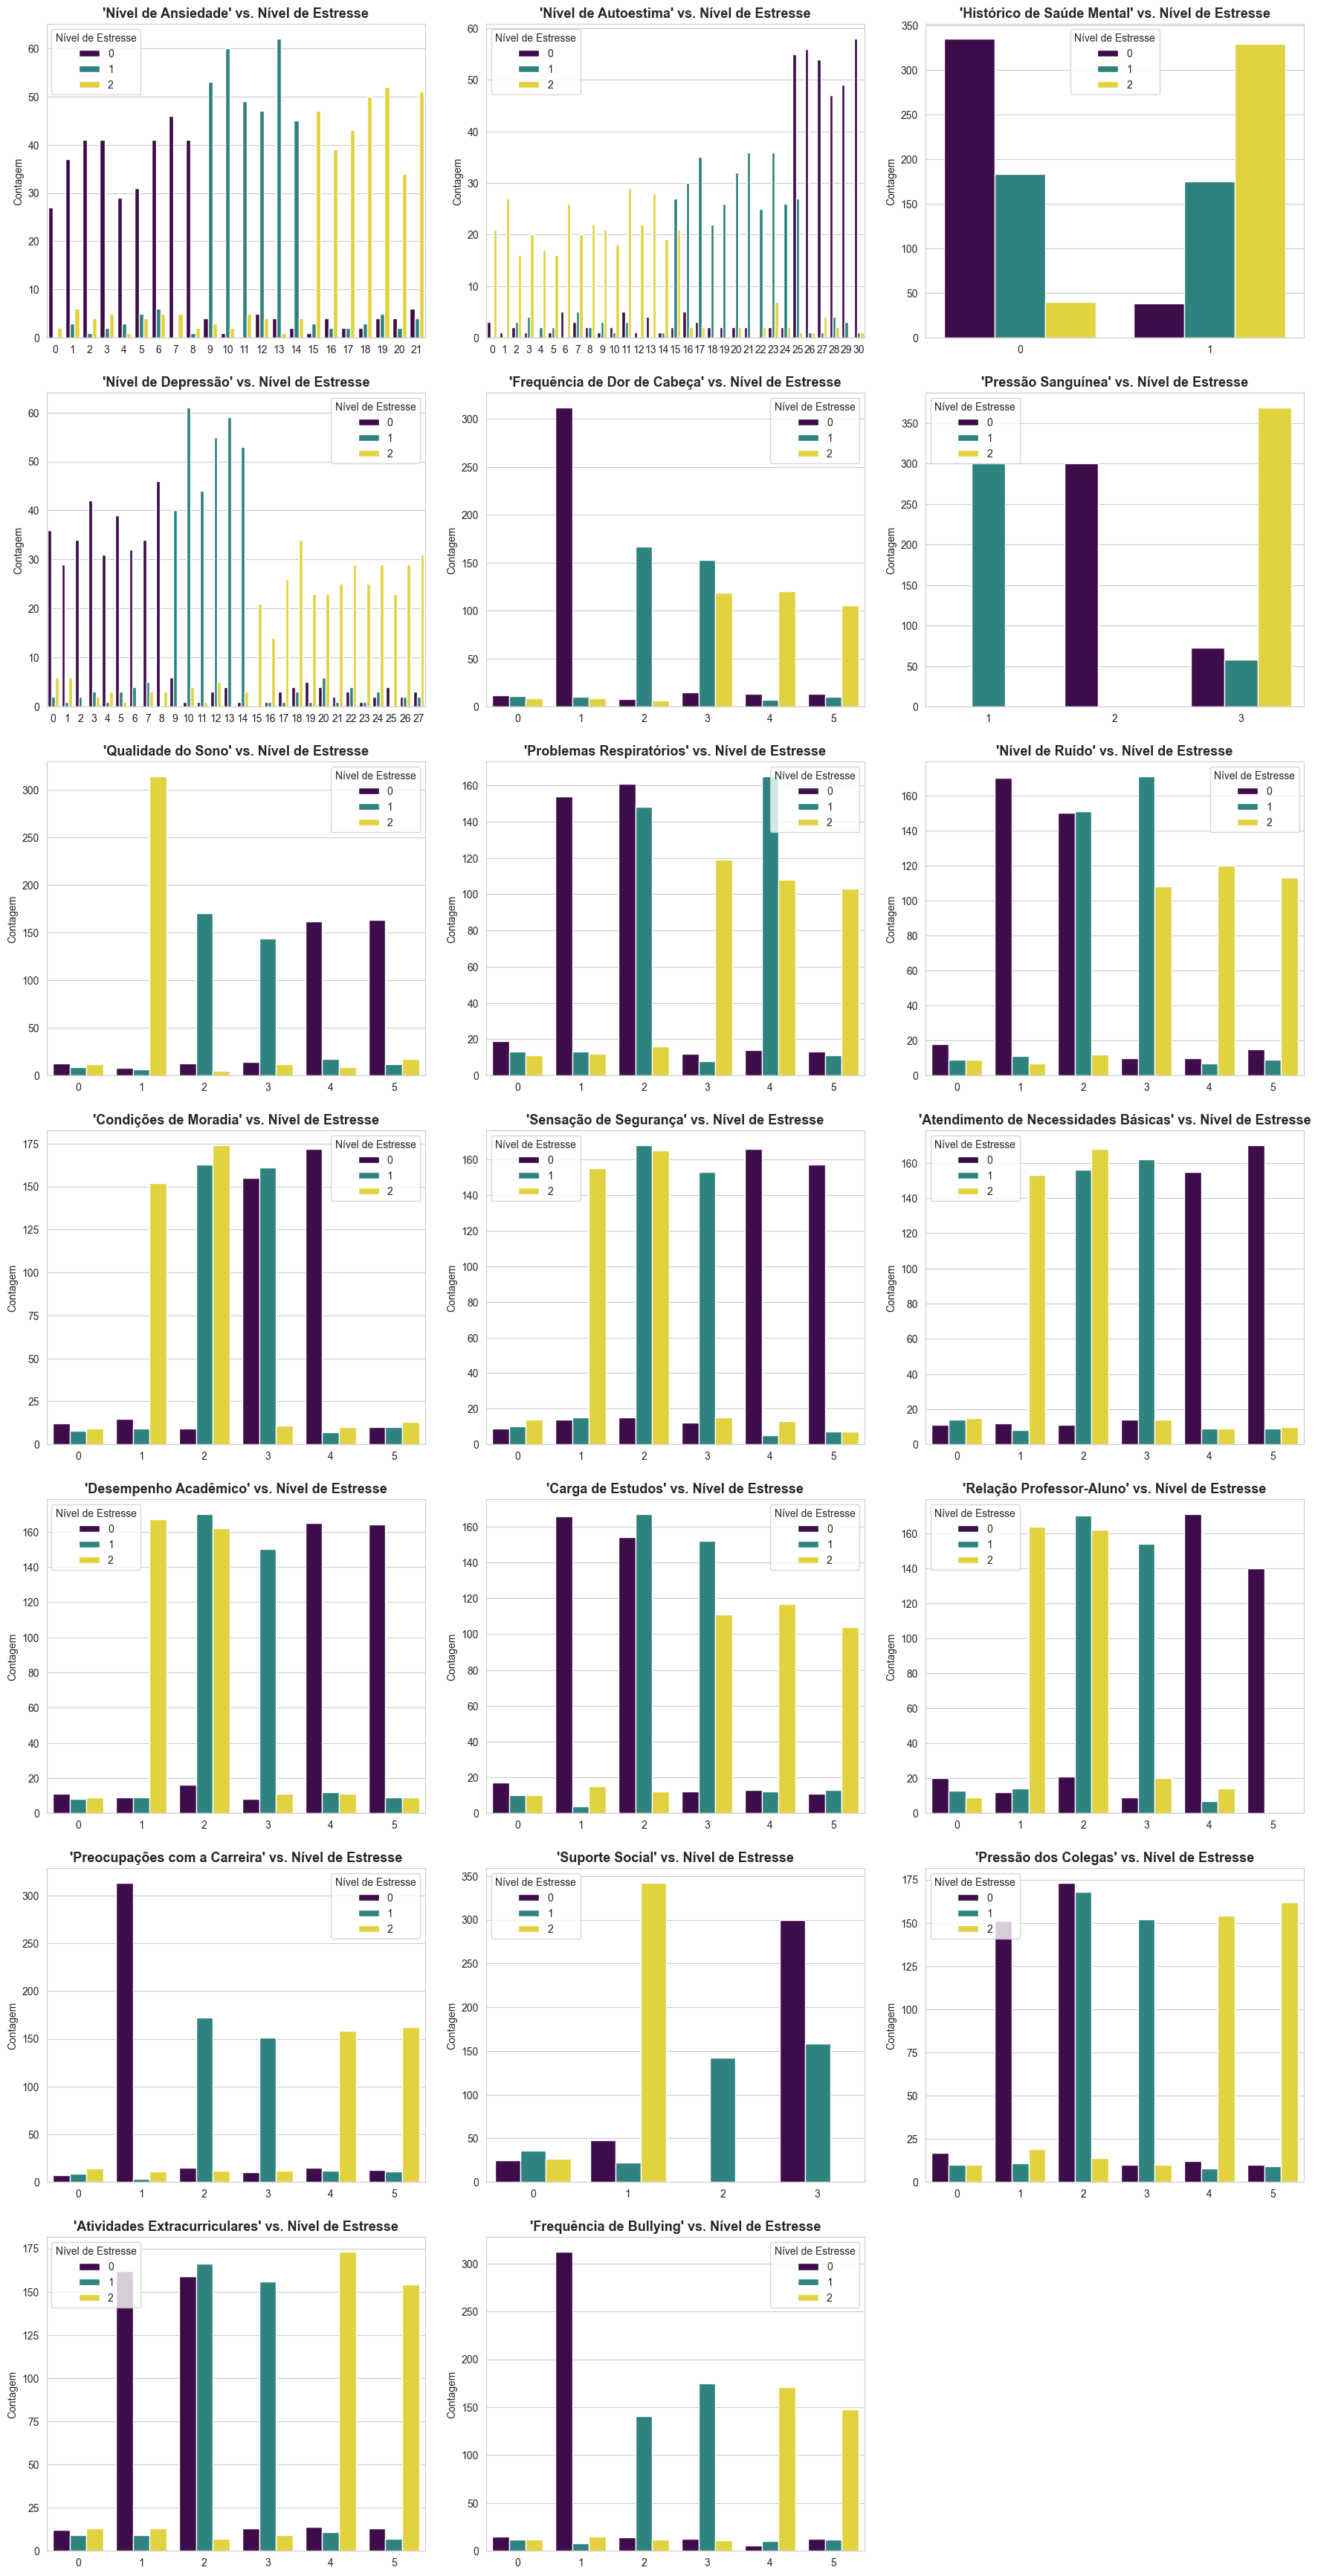

In [8]:
# Reutiliza a lista de features e a grade de visualização da célula anterior
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

# Itera sobre cada feature para criar os gráficos
for i, feature in enumerate(features):
    ax = axes[i]
    titulo_traduzido = FEATURE_TRANSLATOR.get(feature, feature)

    # Cria o gráfico de contagem, segmentado pela variável alvo
    sns.countplot(x=feature, data=df, hue=TARGET_VARIABLE, ax=ax, palette="viridis")

    # Configurações do gráfico
    ax.set_title(
        f"'{titulo_traduzido}' vs. Nível de Estresse", fontsize=13, weight="bold"
    )
    ax.set_xlabel("")
    ax.set_ylabel("Contagem")
    ax.legend(title="Nível de Estresse")

# Oculta eixos não utilizados
for ax in axes[len(features) :]:
    ax.axis("off")

plt.tight_layout(pad=2.0)
plt.show()

#### 📋 Análise dos Resultados

##### **Observações Gerais e Conclusões da Análise Bivariada:**

Nesta etapa, cruzamos cada variável preditiva com a nossa variável alvo (`Nível de Estresse`) para identificar padrões e a força da relação entre elas. Variáveis que mostram uma mudança clara na distribuição do estresse são fortes candidatas a serem bons preditores para o modelo de Machine Learning.

**1. Fatores Acadêmicos e de Carreira:**
* **`Desempenho Acadêmico`**: A **correlação negativa é muito clara**. Estudantes com performance alta (níveis 4 e 5) apresentam predominantemente estresse baixo, enquanto estresse médio e alto são raros. Um forte preditor inverso.
* **`Carga de Estudos`**: Confirma-se uma **forte correlação positiva**. Quanto maior a carga de estudos, maior a proporção de estresse elevado.
* **`Relação Professor-Aluno`**: Existe uma **correlação negativa visível**. Relações melhores com professores estão associadas a menos estresse alto. Um efeito protetor interessante.
* **`Preocupações com a Carreira` e `Atividades Extracurriculares`**: Ambas demonstram uma **forte correlação positiva**. Mais preocupação com o futuro e maior envolvimento em atividades extracurriculares aparecem ligados a níveis mais altos de estresse.

**2. Fatores Psicológicos e de Saúde Mental:**
* **`Nível de Ansiedadel` e `Nível de Depressão`**: Como esperado, ambos mostram uma **correlação positiva fortíssima e linear**. Nos níveis baixos dessas escalas, o estresse é praticamente inexistente. Nos níveis altos, o estresse elevado domina por completo. Essas serão, provavelmente, as variáveis mais influentes do modelo.
* **`Nível de Autoestima`**: Apresenta uma **correlação negativa muito clara**. Quanto maior a autoestima, menor o nível de estresse.
* **`Histórico de Saúde Mental`**: Sendo binária, essa variável mostra seu poder de forma direta. Quem tem histórico de problemas de saúde mental apresenta proporção **significativamente maior** de estresse elevado.

**3. Fatores Sociais e de Relacionamento:**
* **`Suporte Social`**: A análise revela uma relação não linear interessante: O pico de estresse alto ocorre no nível 1 (suporte insuficiente/insatisfatória), sendo até mais alto que no nível 0 (ausência total de suporte). Parece que perceber um suporte "falho" é mais estressante do que não ter suporte nenhum. De modo geral, porém, a tendência é de **forte correlação negativa**.
* **`Frequência de Bullying`**: Uma das **correlações positivas mais fortes**. A proporção de estresse alto cresce de forma alarmante com o aumento do Frequência de Bullying.
* **`Pressão dos Colegas`**: Mostra uma **correlação positiva moderada**. A pressão dos colegas aumenta o estresse, mas de forma menos acentuada que o Frequência de Bullying.

**4. Fatores de Bem-Estar e Ambiente:**
* **`Condições de Moradia`, `Sensação de Segurança`, `Atendimento de Necessidades Básicas` e `Qualidade do Sono`**: Todas mostram **correlação negativa consistente**. Melhores condições de vida, maior segurança, necessidades básicas bem atendidas e maior qualidade de sono estão claramente associadas a níveis mais baixos de estresse.
* **`Nível de Ruído`**: **Correlação positiva forte**. Mais barulho, mais estresse.

**5. Sintomas Fisiológicos:**
* **`Frequência de Dor de Cabeça` e `Problemas Respiratórios`**: Ambas têm uma **correlação positiva muito forte**. A maior frequência desses sintomas está diretamente ligada a uma maior proporção de estresse alto.
* **`Pressão Sanguínea`**: A relação é **extremamente forte e praticamente determinística**. Estresse alto está concentrado quase exclusivamente no grupo com maior nível de pressão arterial. Um divisor de águas claro entre as classes.


##### **Ranking de Preditores Potenciais**

A análise bivariada mostrou que o dataset possui uma boa variedade de preditores. A maioria das variáveis apresenta uma relação clara com o nível de estresse, o que é um sinal positivo para a modelagem. Com base na força e na clareza dessas relações, é possível organizar as variáveis da seguinte maneira:

* **Preditores de Primeira Ordem (Relação Extremamente Forte):**
    * `Nível de Ansiedadel`, `Nível de Depressão`: Quase proxies do próprio estresse.
    * `Pressão Sanguínea`: Divisor de águas entre as classes.
    * `Frequência de Bullying`, `Suporte Social`, `Nível de Autoestima`: Fatores psicossociais com impacto massivo.

* **Preditores de Segunda Ordem (Relação Forte e Consistente):**
    * `Desempenho Acadêmico`, `Carga de Estudos`: A dupla central da vida acadêmica.
    * `Qualidade do Sono`: Fator de bem-estar fundamental.
    * `Frequência de Dor de Cabeça`, `Problemas Respiratórios`: Sintomas físicos associados.
    * `Preocupações com a Carreira`, `Histórico de Saúde Mental`: Indicadores de preocupação e predisposição.

* **Preditores de Terceira Ordem (Relação Clara, porém mais Moderada):**
    * `Condições de Moradia`, `Sensação de Segurança`, `Atendimento de Necessidades Básicas`: Base do bem-estar.
    * `Relação Professor-Aluno`, `Pressão dos Colegas`, `Atividades Extracurriculares`, `Nível de Ruído`: Variáveis contextuais moduladoras.

### 🔎 Análise Multivariada: Matriz de Correlação

* **Objetivo:** Visualizar a correlação linear entre todas as variáveis numéricas do dataset por meio de um mapa de calor (heatmap), permitindo obter uma visão quantitativa da intensidade e da direção das relações lineares entre os pares de variáveis.

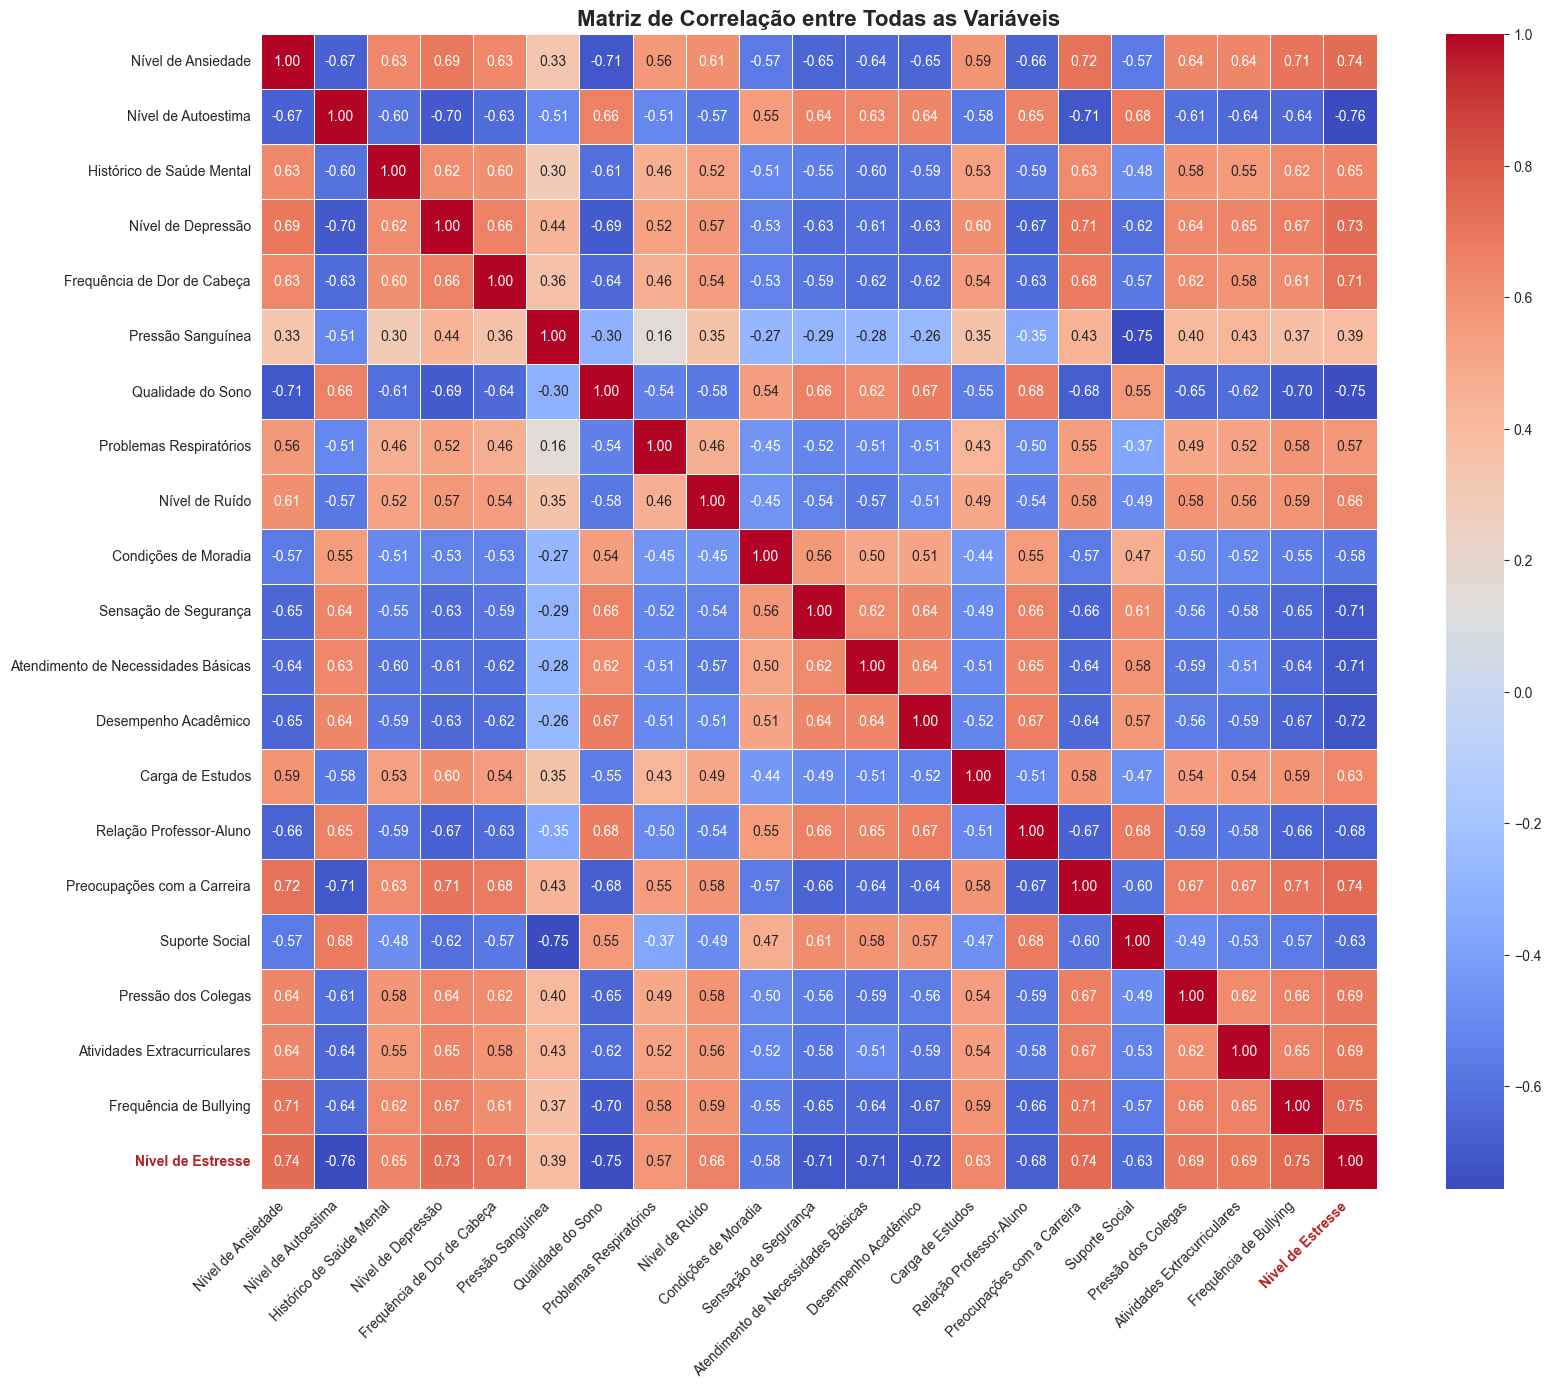


Correlação das Variáveis com 'Nível de Estresse':
Nível de Estresse                      1.000000
Frequência de Bullying                 0.751162
Preocupações com a Carreira            0.742619
Nível de Ansiedade                     0.736795
Nível de Depressão                     0.734379
Frequência de Dor de Cabeça            0.713484
Atividades Extracurriculares           0.692977
Pressão dos Colegas                    0.690684
Nível de Ruído                         0.663371
Histórico de Saúde Mental              0.648644
Carga de Estudos                       0.634156
Problemas Respiratórios                0.573984
Pressão Sanguínea                      0.394200
Condições de Moradia                  -0.581723
Suporte Social                        -0.632497
Relação Professor-Aluno               -0.680163
Atendimento de Necessidades Básicas   -0.708968
Sensação de Segurança                 -0.709602
Desempenho Acadêmico                  -0.720922
Qualidade do Sono                    

In [9]:
# 1. Cálculo e Tradução da Matriz
corr_matrix = df.corr()
translated_corr_matrix = corr_matrix.rename(
    columns=FEATURE_TRANSLATOR, index=FEATURE_TRANSLATOR
)

# 2. Visualização do Heatmap
plt.figure(figsize=(18, 15))
ax = sns.heatmap(
    translated_corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
)
plt.title("Matriz de Correlação entre Todas as Variáveis", fontsize=16, weight="bold")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# 3. Destaque da Variável Alvo nos Eixos
translated_target_name = FEATURE_TRANSLATOR.get(TARGET_VARIABLE, TARGET_VARIABLE)
for label in ax.get_yticklabels() + ax.get_xticklabels():
    if label.get_text() == translated_target_name:
        label.set_weight("bold")
        label.set_color("firebrick")

plt.show()

# 4. Listagem Ordenada da Correlação com a Variável Alvo
print(f"\nCorrelação das Variáveis com '{translated_target_name}':")
correlation_with_target = (
    corr_matrix[TARGET_VARIABLE].rename(FEATURE_TRANSLATOR).sort_values(ascending=False)
)
print(correlation_with_target)

#### 📋 Análise dos Resultados

##### **Correlação com a Variável Alvo (`Nível de Estresse`)**

A lista ordenada de correlações confirma numericamente o que vimos nos gráficos. Podemos dividir os achados em dois grupos principais:

* **Correlações Positivas (Fatores de Risco)**:
    * As variáveis com os maiores valores positivos, como **`Frequência de Bullying` (0.75)**, **`Preocupações com a Carreira` (0.74)**, **`Nível de Ansiedadel` (0.74)** e **`Nível de Depressão` (0.73)**, são os indicadores mais fortes de estresse. Quanto maior o valor dessas variáveis, maior o nível de estresse.

* **Correlações Negativas (Fatores de Proteção)**:
    * As variáveis com os valores negativos mais fortes, como **`Nível de Autoestima` (-0.76)**, **`Qualidade do Sono` (-0.75)**, **`Desempenho Acadêmico` (-0.72)** e **`Sensação de Segurança` (-0.71)**, atuam como protetores. Valores mais altos estão fortemente associados a menos estresse.

**Conclusão**: A análise quantitativa valida completamente nossas observações visuais da análise bivariada. Temos um conjunto robusto de features com forte poder preditivo.

##### **Multicolinearidade entre Features**

Olhando o heatmap, buscamos correlações fortes entre as próprias variáveis preditoras (fora da linha/coluna `Nível de Estresse`). Multicolinearidade ocorre quando duas features medem essencialmente a mesma coisa, o que pode inflar artificialmente a importância de variáveis ou dificultar a interpretação dos resultados.

Alguns pontos de atenção:

* **`Atendimento de Necessidades Básicas` e `Sensação de Segurança` (0.82)**: Correlação muito alta. Faz sentido: a percepção de segurança está diretamente ligada ao atendimento de necessidades básicas.
* **`Frequência de Bullying` e `Nível de Ansiedadel` (0.71)**: Alta correlação, sugerindo que experiências de Frequência de Bullying andam de mãos dadas com níveis elevados de ansiedade.
* **`Nível de Autoestima` e `Qualidade do Sono` (0.69)**: Correlação forte e interessante: melhor autoestima parece estar ligada a melhor qualidade de sono.

**Decisão Técnica**: Embora existam pontos de multicolinearidade, os modelos que pretendemos testar inicialmente (como Random Forest) são robustos a esse fenômeno. Seguindo o princípio da simplicidade (**YAGNI** - *You Aren't Gonna Need It*), **manteremos todas as features por enquanto**. Essa análise fica registrada caso seja necessário refinar o modelo em ciclos futuros de otimização.

##### **Conclusões Finais da EDA**

Concluímos esta fase com as seguintes pontos:
1.  O dataset é de **alta qualidade**, sem dados ausentes ou duplicados.
2.  A variável alvo, `Nível de Estresse`, está **bem balanceada**.
3.  Existem **muitas features com forte correlação** (positiva e negativa) com o estresse, indicando grande potencial preditivo.
4.  Identificamos a presença de **multicolinearidade**, mas optamos por não tratar neste momento para manter a simplicidade.

# 4. 🧹 Pré-processamento e Preparação dos Dados

Com base nas conclusões da Análise Exploratória, nosso dataset já está limpo e todas as variáveis são numéricas. Portanto, o pré-processamento será focado nas seguintes etapas essenciais:
* **Separação de Features e Alvo:** Dividimos nosso DataFrame em X (matriz de features, ou variáveis preditoras) e y (vetor alvo, a variável que queremos prever).
* **Divisão em Conjuntos de Treino e Teste:** Separamos os dados em dois conjuntos: um para treinamento (80% dos dados), utilizado para ensinar o modelo, e outro para teste (20% dos dados), empregado para avaliar seu desempenho em dados inéditos. Utilizamos a estratificação (stratify=y) para garantir que a proporção das classes de estresse fosse mantida em ambos os conjuntos, o que é essencial para datasets balanceados como o nosso.

In [10]:
# Define as features (X) e a variável alvo (y) usando a constante global
# CORREÇÃO: Utiliza a variável `TARGET_VARIABLE` em vez da string "TARGET_VARIABLE"
X = df.drop(TARGET_VARIABLE, axis=1)
y = df[TARGET_VARIABLE]

# Exibe as dimensões para verificação
print(f"Dimensões de X (features): {X.shape}")
print(f"Dimensões de y (alvo): {y.shape}")

Dimensões de X (features): (1100, 20)
Dimensões de y (alvo): (1100,)


In [11]:
# Separa os dados para treinar o modelo e para avaliá-lo em dados não vistos
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% dos dados para o conjunto de teste
    random_state=RANDOM_STATE,  # Garante reprodutibilidade
    stratify=y,  # Mantém a proporção das classes nos dois conjuntos
)

# Verifica as dimensões dos conjuntos resultantes
print(f"Dimensões de X_train: {X_train.shape}")
print(f"Dimensões de X_test:  {X_test.shape}")
print(f"Dimensões de y_train: {y_train.shape}")
print(f"Dimensões de y_test:  {y_test.shape}")

Dimensões de X_train: (880, 20)
Dimensões de X_test:  (220, 20)
Dimensões de y_train: (880,)
Dimensões de y_test:  (220,)


# 5. 🤖 Modelagem e Treinamento

Nesta fase, iniciaremos o processo de construção de modelos de Machine Learning para prever o nível de estresse dos estudantes.Nossa estratégia será divida nas seguintes etapas:
* Criar uma Função de Avaliação
* Estabelecer um Baseline
* Treinar Modelos Candidatos: Decision Tree e Random Forest
* Ao final, comparamos o desempenho dos três modelos para selecionar o melhor candidato.

## 📌 Criar uma Função de Avaliação
* **Objetivo:** Para evitar a repetição de código, criamos uma função auxiliar (evaluate_model) que calcula e exibe as principais métricas de desempenho (acurácia, relatório de classificação) e a matriz de confusão para qualquer modelo treinado.

In [12]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Realiza previsões, calcula e exibe as métricas de avaliação e a matriz de confusão.

    Args:
        model: O modelo treinado a ser avaliado.
        X_test: Dados de teste (features).
        y_test: Dados de teste (alvo).
        model_name (str): Nome do modelo para usar nos títulos.
    """
    # 1. Realiza previsões
    y_pred = model.predict(X_test)

    # 2. Calcula e exibe a acurácia
    accuracy = accuracy_score(y_test, y_pred)
    print(f"--- Avaliação: {model_name} ---")
    print(f"Acurácia: {accuracy:.2%}\n")

    # 3. Exibe o relatório de classificação
    print("Relatório de Classificação:")
    class_names = ["Baixo", "Médio", "Alto"]
    print(classification_report(y_test, y_pred, target_names=class_names))

    # 4. Exibe a matriz de confusão
    print("Matriz de Confusão:")
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, display_labels=class_names
    )
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.show()

## 📌 Estabelecer um Baseline
* **Objetivo:** Treinamos um DummyClassifier, um modelo simples que faz previsões baseadas na distribuição das classes. Ele nos dá um ponto de referência: qualquer modelo mais complexo precisa ter um desempenho superior ao dele para ser considerado útil.

--- Avaliação: Modelo Baseline (Dummy Classifier) ---
Acurácia: 34.55%

Relatório de Classificação:
              precision    recall  f1-score   support

       Baixo       0.34      0.34      0.34        74
       Médio       0.34      0.32      0.33        72
        Alto       0.35      0.38      0.37        74

    accuracy                           0.35       220
   macro avg       0.35      0.35      0.34       220
weighted avg       0.35      0.35      0.35       220

Matriz de Confusão:


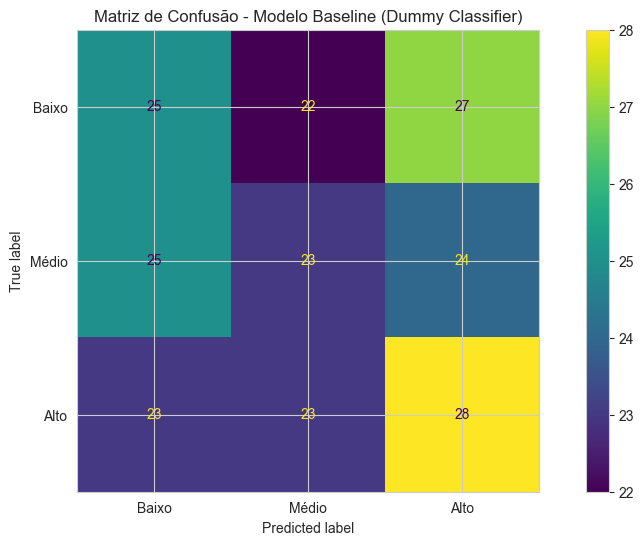

In [13]:
# 1. Instancia e treina o modelo baseline
baseline_model = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
baseline_model.fit(X_train, y_train)

# 2. Avalia o modelo usando a função auxiliar
evaluate_model(baseline_model, X_test, y_test, "Modelo Baseline (Dummy Classifier)")

## 📌 Modelo 1: Decision Tree
* **Objetivo:** Com o baseline estabelecido, vamos agora treinar nosso primeiro modelo preditivo real. Decision tree é um modelo interpretável que aprende regras de decisão a partir dos dados.

--- Avaliação: Árvore de Decisão ---
Acurácia: 85.45%

Relatório de Classificação:
              precision    recall  f1-score   support

       Baixo       0.86      0.80      0.83        74
       Médio       0.82      0.90      0.86        72
        Alto       0.89      0.86      0.88        74

    accuracy                           0.85       220
   macro avg       0.86      0.85      0.85       220
weighted avg       0.86      0.85      0.85       220

Matriz de Confusão:


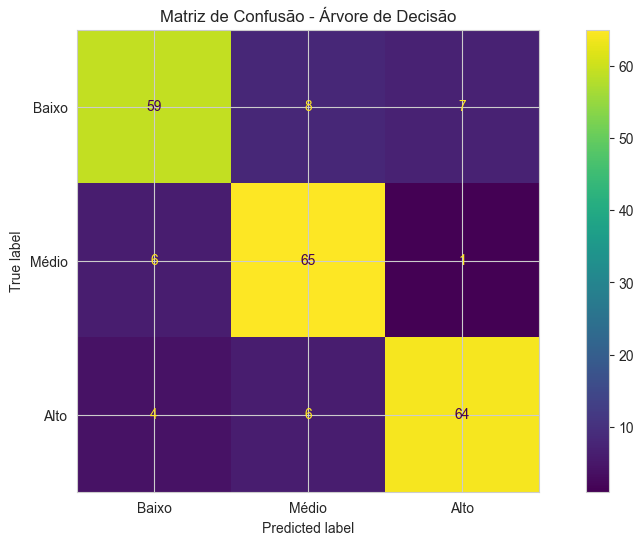

In [14]:
# 1. Instancia e treina o modelo
tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_model.fit(X_train, y_train)

# 2. Avalia o modelo
evaluate_model(tree_model, X_test, y_test, "Árvore de Decisão")

## 📌 Modelo 2: Random Forest
* **Objetivo:** O modelo de Árvore de Decisão entregou um ótimo resultado. Agora, vamos dar um passo além e testar o Random Forest — um modelo de ensemble que combina várias árvores para gerar previsões mais consistentes e reduzir o risco de overfitting.

--- Avaliação: Random Forest ---
Acurácia: 89.09%

Relatório de Classificação:
              precision    recall  f1-score   support

       Baixo       0.93      0.84      0.88        74
       Médio       0.89      0.93      0.91        72
        Alto       0.86      0.91      0.88        74

    accuracy                           0.89       220
   macro avg       0.89      0.89      0.89       220
weighted avg       0.89      0.89      0.89       220

Matriz de Confusão:


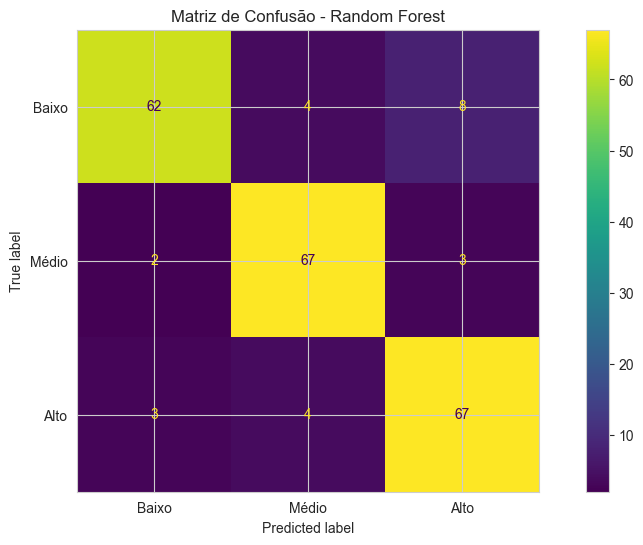

In [15]:
# 1. Instancia e treina o modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)

# 2. Avalia o modelo
evaluate_model(rf_model, X_test, y_test, "Random Forest")

## 📌 Comparação dos Modelos e Escolha Final

Após treinar e avaliar três modelos distintos, podemos comparar seus resultados de acurácia para selecionar o mais performático.

| Modelo | Acurácia no Conjunto de Teste |
| :--- | :--- |
| Baseline (Dummy Classifier) | 35% |
| Árvore de Decisão | 85% |
| **Random Forest** | **89%** |

### Modelo Escolhido

Depois de comparar os modelos, o **Random Forest Classifier** se destacou como a melhor escolha para este projeto. Três razões principais:
1. **Acurácia mais alta:** Atingiu 89%, o melhor resultado entre todos os modelos testados.
2. **Equilíbrio entre as classes:** O `f1-score` médio foi superior e mais bem distribuído, indicando que o modelo não favorece uma classe em detrimento de outra.
3. **Maior confiabilidade:** Por ser um ensemble, o Random Forest tende a generalizar melhor que uma árvore isolada, oferecendo previsões mais estáveis em dados novos.

# 6. 🛠️ Otimização de Hiperparâmetros

O Random Forest apresentou o melhor desempenho com seus parâmetros padrão (como n_estimators=100). Embora seja possível ir além e ajustar hiperparâmetros — testando diferentes números de árvores, profundidades máximas, critérios de divisão, entre outros — por meio de técnicas como Grid Search ou Random Search com validação cruzada, optamos por não realizar essa etapa aqui.
Para o escopo atual, o desempenho do modelo já é excelente e atende aos objetivos do projeto. Caso seja necessário espremer mais alguns pontos percentuais de performance no futuro, a otimização de hiperparâmetros seria o próximo passo natural.

# 7. 🏁 Conclusão

## 📌 Exportação
A última etapa do nosso pipeline de desenvolvimento é salvar (ou "serializar") o objeto do modelo treinado em um arquivo. Isso nos permite recarregar o modelo treinado em outros ambientes ou aplicações — como nosso dashboard em Streamlit — sem a necessidade de refazer todo o processo de treinamento. Utilizamos a biblioteca `joblib` para esta tarefa, que é eficiente para salvar objetos Python que contêm grandes arrays de dados, como os modelos do Scikit-Learn.

In [16]:
# Define o caminho e garante que o diretório exista
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "student_stress_rf_model.joblib")

# Salva o objeto do modelo no arquivo
joblib.dump(rf_model, model_path)

print(f"✅ Modelo Random Forest salvo com sucesso em: {model_path}")

✅ Modelo Random Forest salvo com sucesso em: ../models\student_stress_rf_model.joblib


## 📌 Resumo do Projeto
Percorremos todo o ciclo de um projeto de Machine Learning: desde a exploração inicial dos dados até a criação e exportação de um modelo preditivo funcional.
### Principais Conclusões
* O dataset é limpo e bem estruturado — não tivemos que lidar com valores ausentes, o que acelerou bastante o processo.
* A análise exploratória mostrou que a variável alvo está razoavelmente balanceada e que várias features possuem correlação significativa com os níveis de estresse.
* O Random Forest alcançou uma acurácia consideravelmente alta e desempenho superior tanto ao baseline quanto à Árvore de Decisão individual. Isso sugere que os padrões nos dados são complexos e se beneficiam de uma abordagem ensemble.
* O modelo final foi salvo com sucesso e está pronto para ser integrado em aplicações que realizem previsões em tempo real.